### Problem 1
#### Milad Heidari
#### Student Number: 98101469

In [1]:
import torch
import math
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Lambda
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix
from functools import reduce
from operator import add, mul
from torchvision.ops import DropBlock2d

In [2]:
# set device to cuda if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

#### A)

In [3]:
transform_to_tensor = ToTensor()

def input_transform(img):
    img = img.resize((136, 102))
    return transform_to_tensor(img)

dataset = ImageFolder(root='./data/Shoe vs Sandal vs Boot Dataset/', transform=input_transform)

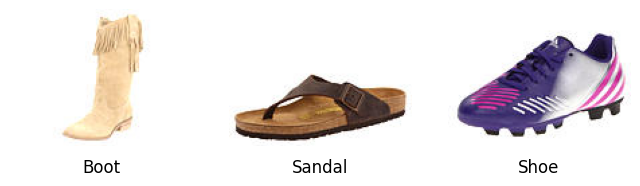

In [4]:
label_map = {0: 'Boot', 1: 'Sandal', 2: 'Shoe'}
sample_dataloader = DataLoader(dataset, shuffle=True)
data_iterator = iter(sample_dataloader)

fig = plt.figure(figsize=(8, 6))
for i in range(3):
    while True:
        X, y = next(data_iterator)
        if y == i:
            ax = fig.add_subplot(1, 3, i+1)
            ax.set_axis_off()
            img = X.squeeze().permute(1, 2, 0)
            ax.imshow(img.cpu())
            ax.set_title(label_map[i], y=-0.25)
            break

In [5]:
# train-test split
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

In [6]:
#checking size of test and train set
print(f'size of the training set: {len(train_set)}')
print(f'size of the test set: {len(test_set)}')

size of the training set: 10500
size of the test set: 4500


#### B, C)

In [7]:
# define network
class MLPNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(41616, 1024),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(32, 3),
            nn.ReLU(),
        )
        self.sigmoid = nn.Sigmoid()
        
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        x = self.sigmoid(x)
        return x

In [8]:
# create an instance of the model defined above
model = MLPNetwork().to(device)
model.train()

MLPNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=41616, out_features=1024, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=64, bias=True)
    (10): Dropout(p=0.2, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=32, bias=True)
    (13): Dropout(p=0.2, inplace=False)
    (14): ReLU()
    (15): Linear(in_features=32, out_features=3, bias=True)
    (16): ReLU()
  )
  (sigmoid): Sigmoid()
)

In [9]:
# setting hyperparameters
learning_rate = 1e-5
batch_size = 16
epochs = 10

In [10]:
# initialize the loss function and choose an optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [7]:
def train_loop(dataloader, model, loss_fn, optimizer, log_prefix=None):
    global train_idx
    model.train()
    size = len(dataloader.dataset)
    num_correct = 0
    for batch_num, (X, y) in enumerate(dataloader):
        # forward prop
        X = X.to(torch.float32).to(device)
        y = y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        writer.add_scalar(log_prefix, loss.item(), train_idx)
        train_idx += 1
        num_correct += (y_pred.argmax(dim=1) == y).sum().item()
        # back prop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    accuracy = num_correct / size
    print(f'train_loss: {loss.item()}')
    print(f'Train Accuracy: {np.round(accuracy*100,2)}%')
    
            
def test_loop(dataloader, model, loss_fn, log_prefix=None):
    global test_idx
    model.eval()
    size = len(dataloader.dataset)
    num_correct = 0
    with torch.no_grad():
        for batch_num, (X, y) in enumerate(dataloader):
            X = X.to(torch.float32).to(device)
            y = y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            writer.add_scalar(log_prefix, loss.item(), test_idx)
            test_idx += 1
            num_correct += (y_pred.argmax(dim=1) == y).sum().item()
                        
    accuracy = num_correct / size
    print(f'Test Accuracy: {np.round(accuracy*100, 2)}%')
    

In [12]:
train_idx = 0
test_idx = 0
writer = SummaryWriter()

for i in range(1, epochs+1):
    print(f'epoch {i}', '='*50)
    train_loop(train_dataloader, model, loss_fn, optimizer, log_prefix='MLP/train')
    test_loop(test_dataloader, model, loss_fn, log_prefix='MLP/test')
    print()
    
writer.flush()

epoch 1 ==================================================
train_loss: 1.0510132312774658
Train Accuracy: 57.04%
Test Accuracy: 67.44%

epoch 2 ==================================================
train_loss: 0.9703036546707153
Train Accuracy: 67.17%
Test Accuracy: 76.22%

epoch 3 ==================================================
train_loss: 0.975532591342926
Train Accuracy: 72.9%
Test Accuracy: 78.18%

epoch 4 ==================================================
train_loss: 0.8953139781951904
Train Accuracy: 77.33%
Test Accuracy: 80.71%

epoch 5 ==================================================
train_loss: 0.8669062852859497
Train Accuracy: 79.9%
Test Accuracy: 81.93%

epoch 6 ==================================================
train_loss: 0.8213865756988525
Train Accuracy: 82.56%
Test Accuracy: 82.56%

epoch 7 ==================================================
train_loss: 1.0838754177093506
Train Accuracy: 83.68%
Test Accuracy: 81.42%

epoch 8 ===========================================

Learning curve is shown in the image below. Smoothing factor is set to 0.95.

![MLP_loss.png](./images/MLP_loss.png)

In [13]:
# torch.save(model, 'P1_best_MLP.pt')
model = torch.load('P1_best_MLP.pt')

In [17]:
# evaluating model

def evaluation_loop(dataloader, model):
    model.eval()
    y_predicted = []
    y_actual = []
    with torch.no_grad():
        for batch_num, (X, y) in enumerate(dataloader):
            X = X.to(torch.float32).to(device)
            y = y.to(device)
            y_pred = model(X)
            y_actual += [z.cpu().item() for z in y]
            y_predicted += [z.cpu().item() for z in y_pred.argmax(dim=1)]
            
    return y_actual, y_predicted

In [ ]:
y_actual, y_predicted = evaluation_loop(test_dataloader, model)

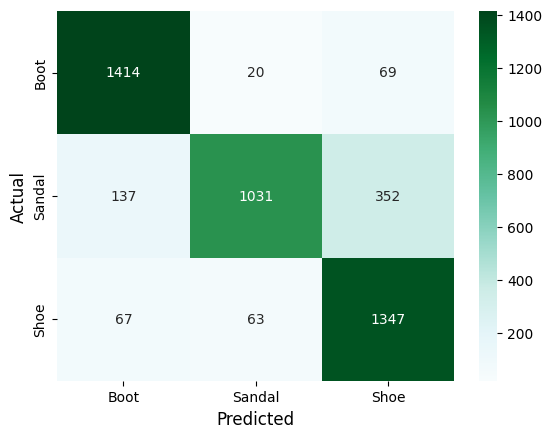

In [15]:
# confusion matrix
confmat = confusion_matrix(y_actual, y_predicted)
class_names = ['Boot', 'Sandal', 'Shoe']
sns.heatmap(confmat, xticklabels=class_names, yticklabels=class_names, cmap='BuGn', annot=True, fmt='d')
plt.xlabel('Predicted', size=12)
plt.ylabel('Actual', size=12);

In [16]:
precisions = []
recalls = []

for i, class_name in enumerate(class_names):
    precision = confmat[i, i] / confmat[:, i].sum()
    recall = confmat[i, i] / confmat[i, :].sum()
    precisions.append(precision)
    recalls.append(recall)
    print(f'for class {class_name}: ')
    print(f'precision: {np.round(precision, 2)}')
    print(f'recall: {np.round(recall, 2)}')
    print()
    
print('overall: ')
print(f'precision: {np.round(np.mean(precisions), 2)}')
print(f'recall: {np.round(np.mean(recalls), 2)}')

for class Boot: 
precision: 0.87
recall: 0.94

for class Sandal: 
precision: 0.93
recall: 0.68

for class Shoe: 
precision: 0.76
recall: 0.91

overall: 
precision: 0.85
recall: 0.84


In [17]:
# compute the number of parameters
num_params = reduce(add, [reduce(mul, param.shape, 1) for param in model.parameters()], 0)
print(f'number of parameters: {num_params}')

number of parameters: 43290563


#### D)

In [5]:
class CNNNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 512, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 64, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 16, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.mlp_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(560, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 3),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.mlp_layers(x)
        return x

In [26]:
model = CNNNetwork().to(device)

In [13]:
# setting hyperparameters
learning_rate = 1e-4
batch_size = 16
epochs = 5

In [14]:
# initialize the loss function and choose an optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [29]:
train_idx = 0
test_idx = 0
writer = SummaryWriter()
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

for i in range(1, epochs+1):
    print(f'epoch {i}', '='*50)
    train_loop(train_dataloader, model, loss_fn, optimizer, log_prefix='CNN/train')
    test_loop(test_dataloader, model, loss_fn, log_prefix='CNN/test')
    print()
    
writer.flush()

epoch 1 ==================================================
train_loss: 0.5729437470436096
Train Accuracy: 88.73%
Test Accuracy: 96.0%

epoch 2 ==================================================
train_loss: 0.5515772104263306
Train Accuracy: 96.46%
Test Accuracy: 95.93%

epoch 3 ==================================================
train_loss: 0.5520834922790527
Train Accuracy: 97.65%
Test Accuracy: 97.24%

epoch 4 ==================================================
train_loss: 0.5997011065483093
Train Accuracy: 98.23%
Test Accuracy: 97.87%

epoch 5 ==================================================
train_loss: 0.6557820439338684
Train Accuracy: 98.33%
Test Accuracy: 95.91%



Learning curve is shown in the image below. Smoothing factor is set to 0.95.

![MLP_loss.png](./images/CNN_loss.png)

In [6]:
# torch.save(model, 'P1_best_CNN.pt')
model = torch.load('P1_best_CNN.pt')

In [15]:
# evaluating model
y_actual, y_predicted = evaluation_loop(test_dataloader, model)

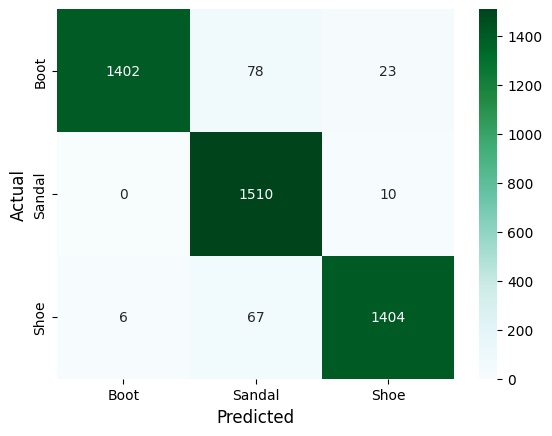

In [32]:
# confusion matrix
confmat = confusion_matrix(y_actual, y_predicted)
class_names = ['Boot', 'Sandal', 'Shoe']
sns.heatmap(confmat, xticklabels=class_names, yticklabels=class_names, cmap='BuGn', annot=True, fmt='d')
plt.xlabel('Predicted', size=12)
plt.ylabel('Actual', size=12);

In [34]:
precisions = []
recalls = []

for i, class_name in enumerate(class_names):
    precision = confmat[i, i] / confmat[:, i].sum()
    recall = confmat[i, i] / confmat[i, :].sum()
    precisions.append(precision)
    recalls.append(recall)
    print(f'for class {class_name}: ')
    print(f'precision: {np.round(precision, 2)}')
    print(f'recall: {np.round(recall, 2)}')
    print()
    
print('overall: ')
print(f'precision: {np.round(np.mean(precisions), 2)}')
print(f'recall: {np.round(np.mean(recalls), 2)}')

for class Boot: 
precision: 1.0
recall: 0.93

for class Sandal: 
precision: 0.91
recall: 0.99

for class Shoe: 
precision: 0.98
recall: 0.95

overall: 
precision: 0.96
recall: 0.96


In [35]:
# compute the number of parameters
num_params = reduce(add, [reduce(mul, param.shape, 1) for param in model.parameters()], 0)
print(f'number of parameters: {num_params}')

number of parameters: 1533427


#### E)

CNN model's performance is much better than MLP.

#### F)

Normal dropout randomly drops units in the feature map of a layer, but due to high correlation between neighbor units, when one unit is set to zero, its neighbors can carry its activation information thus the contribution of that unit is not completely removed. In order to make it so, we drop a contigous regions from a feature map of a layer instead of dropping out independent random units. The following image illustrates how blockdrop works:

![blockdrop.webp](./images/blockdrop.webp)

In [22]:
# CNN network with block dropout

class CNNNetwork2(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 512, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(512),
            
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(256),
            DropBlock2d(p=0.2, block_size=7),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 64, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(64),
            DropBlock2d(p=0.2, block_size=7),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 16, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(16),
            DropBlock2d(p=0.2, block_size=7),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.mlp_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(560, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 3),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.mlp_layers(x)
        return x

In [23]:
model = CNNNetwork2().to(device)

In [24]:
# setting hyperparameters
learning_rate = 1e-4
batch_size = 16
epochs = 5

In [25]:
# initialize the loss function and choose an optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [28]:
train_idx = 0
test_idx = 0
writer = SummaryWriter()
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

for i in range(1, epochs+1):
    print(f'epoch {i}', '='*50)
    train_loop(train_dataloader, model, loss_fn, optimizer, log_prefix='CNN_blockdrop/train')
    test_loop(test_dataloader, model, loss_fn, log_prefix='CNN_blockdrop/test')
    print()
    
writer.flush()

epoch 1 ==================================================
train_loss: 0.8021425604820251
Train Accuracy: 86.17%
Test Accuracy: 94.11%

epoch 2 ==================================================
train_loss: 0.7986667156219482
Train Accuracy: 94.7%
Test Accuracy: 96.58%

epoch 3 ==================================================
train_loss: 0.5514513850212097
Train Accuracy: 95.76%
Test Accuracy: 97.2%

epoch 4 ==================================================
train_loss: 0.7977259159088135
Train Accuracy: 96.35%
Test Accuracy: 96.87%

epoch 5 ==================================================
train_loss: 0.5514922738075256
Train Accuracy: 96.57%
Test Accuracy: 97.62%



Learning curve is shown in the image below. Smoothing factor is set to 0.95.

![MLP_loss.png](./images/CNN_blockdrop_loss.png)

In [29]:
# torch.save(model, 'P1_best_CNN_blockdrop.pt')
model = torch.load('P1_best_CNN_blockdrop.pt')

In [30]:
# evaluating model
y_actual, y_predicted = evaluation_loop(test_dataloader, model)

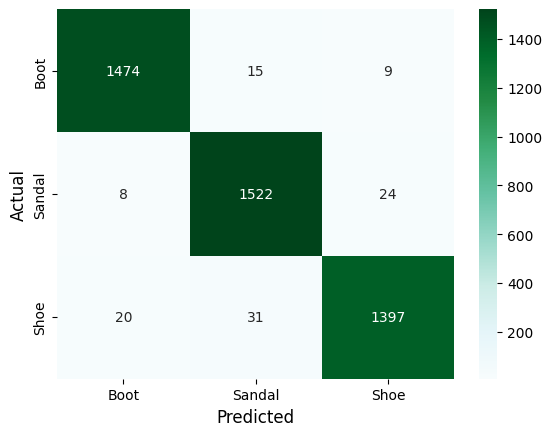

In [31]:
# confusion matrix
confmat = confusion_matrix(y_actual, y_predicted)
class_names = ['Boot', 'Sandal', 'Shoe']
sns.heatmap(confmat, xticklabels=class_names, yticklabels=class_names, cmap='BuGn', annot=True, fmt='d')
plt.xlabel('Predicted', size=12)
plt.ylabel('Actual', size=12);

In [32]:
precisions = []
recalls = []

for i, class_name in enumerate(class_names):
    precision = confmat[i, i] / confmat[:, i].sum()
    recall = confmat[i, i] / confmat[i, :].sum()
    precisions.append(precision)
    recalls.append(recall)
    print(f'for class {class_name}: ')
    print(f'precision: {np.round(precision, 2)}')
    print(f'recall: {np.round(recall, 2)}')
    print()
    
print('overall: ')
print(f'precision: {np.round(np.mean(precisions), 2)}')
print(f'recall: {np.round(np.mean(recalls), 2)}')

for class Boot: 
precision: 0.98
recall: 0.98

for class Sandal: 
precision: 0.97
recall: 0.98

for class Shoe: 
precision: 0.98
recall: 0.96

overall: 
precision: 0.98
recall: 0.98


In [33]:
# compute the number of parameters
num_params = reduce(add, [reduce(mul, param.shape, 1) for param in model.parameters()], 0)
print(f'number of parameters: {num_params}')

number of parameters: 1533427


#### G)

In [8]:
# CNN network using matrix factorization

class CNNNetwork2(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.cnn_layers = nn.Sequential(
            
            nn.Conv2d(3, 256, kernel_size=(3, 1), stride=1, padding='same'),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=(1, 3), stride=1, padding='same'),
            nn.BatchNorm2d(256),
            DropBlock2d(p=0.2, block_size=7),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(256, 64, kernel_size=(3, 1), stride=1, padding='same'),
            nn.ReLU(), 
            nn.Conv2d(64, 64, kernel_size=(1, 3), stride=1, padding='same'),
            nn.BatchNorm2d(64),
            DropBlock2d(p=0.2, block_size=7),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(64, 16, kernel_size=(3, 1), stride=1, padding='same'),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=(3, 1), stride=1, padding='same'),
            nn.BatchNorm2d(16),
            DropBlock2d(p=0.2, block_size=7),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.mlp_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2816, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 3),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.mlp_layers(x)
        return x

In [9]:
model = CNNNetwork2().to(device)

In [10]:
# setting hyperparameters
learning_rate = 1e-4
batch_size = 16
epochs = 5

In [11]:
# initialize the loss function and choose an optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [12]:
train_idx = 0
test_idx = 0
writer = SummaryWriter()
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

for i in range(1, epochs+1):
    print(f'epoch {i}', '='*50)
    train_loop(train_dataloader, model, loss_fn, optimizer, log_prefix='CNN_kernel_factorization/train')
    test_loop(test_dataloader, model, loss_fn, log_prefix='CNN_kernel_factorization/test')
    print()
    
writer.flush()

epoch 1 ==================================================
train_loss: 0.7158586978912354
Train Accuracy: 84.84%
Test Accuracy: 92.91%

epoch 2 ==================================================
train_loss: 0.8635236620903015
Train Accuracy: 93.74%
Test Accuracy: 95.58%

epoch 3 ==================================================
train_loss: 0.6121535897254944
Train Accuracy: 95.09%
Test Accuracy: 96.73%

epoch 4 ==================================================
train_loss: 0.5515545606613159
Train Accuracy: 95.89%
Test Accuracy: 96.76%

epoch 5 ==================================================
train_loss: 0.5514726638793945
Train Accuracy: 96.62%
Test Accuracy: 97.04%



Learning curve is shown in the image below. Smoothing factor is set to 0.95.

![MLP_loss.png](./images/CNN_factorization.png)

In [15]:
# torch.save(model, 'P1_best_CNN_kernel_factorization.pt')
model = torch.load('P1_best_CNN_kernel_factorization.pt')

In [18]:
# evaluating model
y_actual, y_predicted = evaluation_loop(test_dataloader, model)

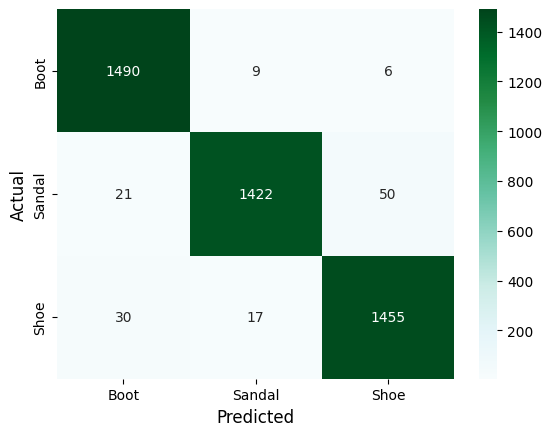

In [19]:
# confusion matrix
confmat = confusion_matrix(y_actual, y_predicted)
class_names = ['Boot', 'Sandal', 'Shoe']
sns.heatmap(confmat, xticklabels=class_names, yticklabels=class_names, cmap='BuGn', annot=True, fmt='d')
plt.xlabel('Predicted', size=12)
plt.ylabel('Actual', size=12);

In [20]:
precisions = []
recalls = []

for i, class_name in enumerate(class_names):
    precision = confmat[i, i] / confmat[:, i].sum()
    recall = confmat[i, i] / confmat[i, :].sum()
    precisions.append(precision)
    recalls.append(recall)
    print(f'for class {class_name}: ')
    print(f'precision: {np.round(precision, 2)}')
    print(f'recall: {np.round(recall, 2)}')
    print()
    
print('overall: ')
print(f'precision: {np.round(np.mean(precisions), 2)}')
print(f'recall: {np.round(np.mean(recalls), 2)}')

for class Boot: 
precision: 0.97
recall: 0.99

for class Sandal: 
precision: 0.98
recall: 0.95

for class Shoe: 
precision: 0.96
recall: 0.97

overall: 
precision: 0.97
recall: 0.97


In [21]:
# compute the number of parameters
num_params = reduce(add, [reduce(mul, param.shape, 1) for param in model.parameters()], 0)
print(f'number of parameters: {num_params}')

number of parameters: 1023811


We see that number of parameters has decreased noticeably and the training process is faster than before. Kernel factorization brings us the best of two worlds: it makes the network more non-linear as well as decreasing the numbser of parameters.